In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../Code')

from utility_functions import *
from weight_matrix import *
from parameters import *
from sim_network_EI import sim_network_Perturb
from scipy.special import lambertw, exp1, expi, hyp2f1, gamma, gammaincc
from scipy import optimize, integrate
import mpmath as mp
from natsort import natsorted
from glob import glob
from phi import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [2]:
# E-J Plane
E_fixed = -0.5
J = np.arange(-4.0, 15.01, 0.01)
theta = np.arange(0.8, 1.5, 0.2).round(2)
E_plot_theta = np.zeros((len(theta), len(J)))
g_plot_theta = np.zeros((len(theta), len(J)))

for i in range(len(theta)):
    E_plot_theta[i,:] = 2 * theta[i] - J
    g_plot_theta[i,:] = 1 - ((2 * theta[i] - E_fixed) / J)

In [3]:
E_plot = np.arange(0.0, 2.1, 0.1)
J_plot = np.arange(0.0, 4.1, 0.2)
J_plot_Jg = np.arange(2.0, 4.1, 0.1)
g_plot = np.arange(0.0, 1.1, 0.1)

In [4]:
filename = '../Data/Figure 7/200Data_Exp.npz'
data = np.load(filename)

fr_Sim_L_EJ = data['arr_0']
fr_Sim_H_EJ = data['arr_1']

fr_MF_L_EJ = data['arr_4']
fr_MF_H_EJ = data['arr_5']

fr_Sim_H_EJ = fr_Sim_H_EJ.reshape((len(E_plot), len(J_plot)))
fr_MF_H_EJ = fr_MF_H_EJ.reshape((len(E_plot), len(J_plot)))

fr_Sim_L_EJ = np.flip(fr_Sim_L_EJ.reshape((len(E_plot), len(J_plot))), axis=0)
fr_MF_L_EJ = np.flip(fr_MF_L_EJ.reshape((len(E_plot), len(J_plot))), axis=0)

In [5]:
filename = '../Data/Figure 7/300Data_Exp_Jg.npz'
data = np.load(filename)

fr_Sim_L_Jg = data['arr_0']
fr_Sim_H_Jg = data['arr_1']

fr_MF_L_Jg = data['arr_2']
fr_MF_H_Jg = data['arr_3']

fr_Sim_H_Jg = fr_Sim_H_Jg.reshape((len(g_plot), len(J_plot_Jg)))
fr_MF_H_Jg = fr_MF_H_Jg.reshape((len(g_plot), len(J_plot_Jg)))

fr_Sim_L_Jg = fr_Sim_L_Jg.reshape((len(g_plot), len(J_plot_Jg)))
fr_MF_L_Jg = fr_MF_L_Jg.reshape((len(g_plot), len(J_plot_Jg)))

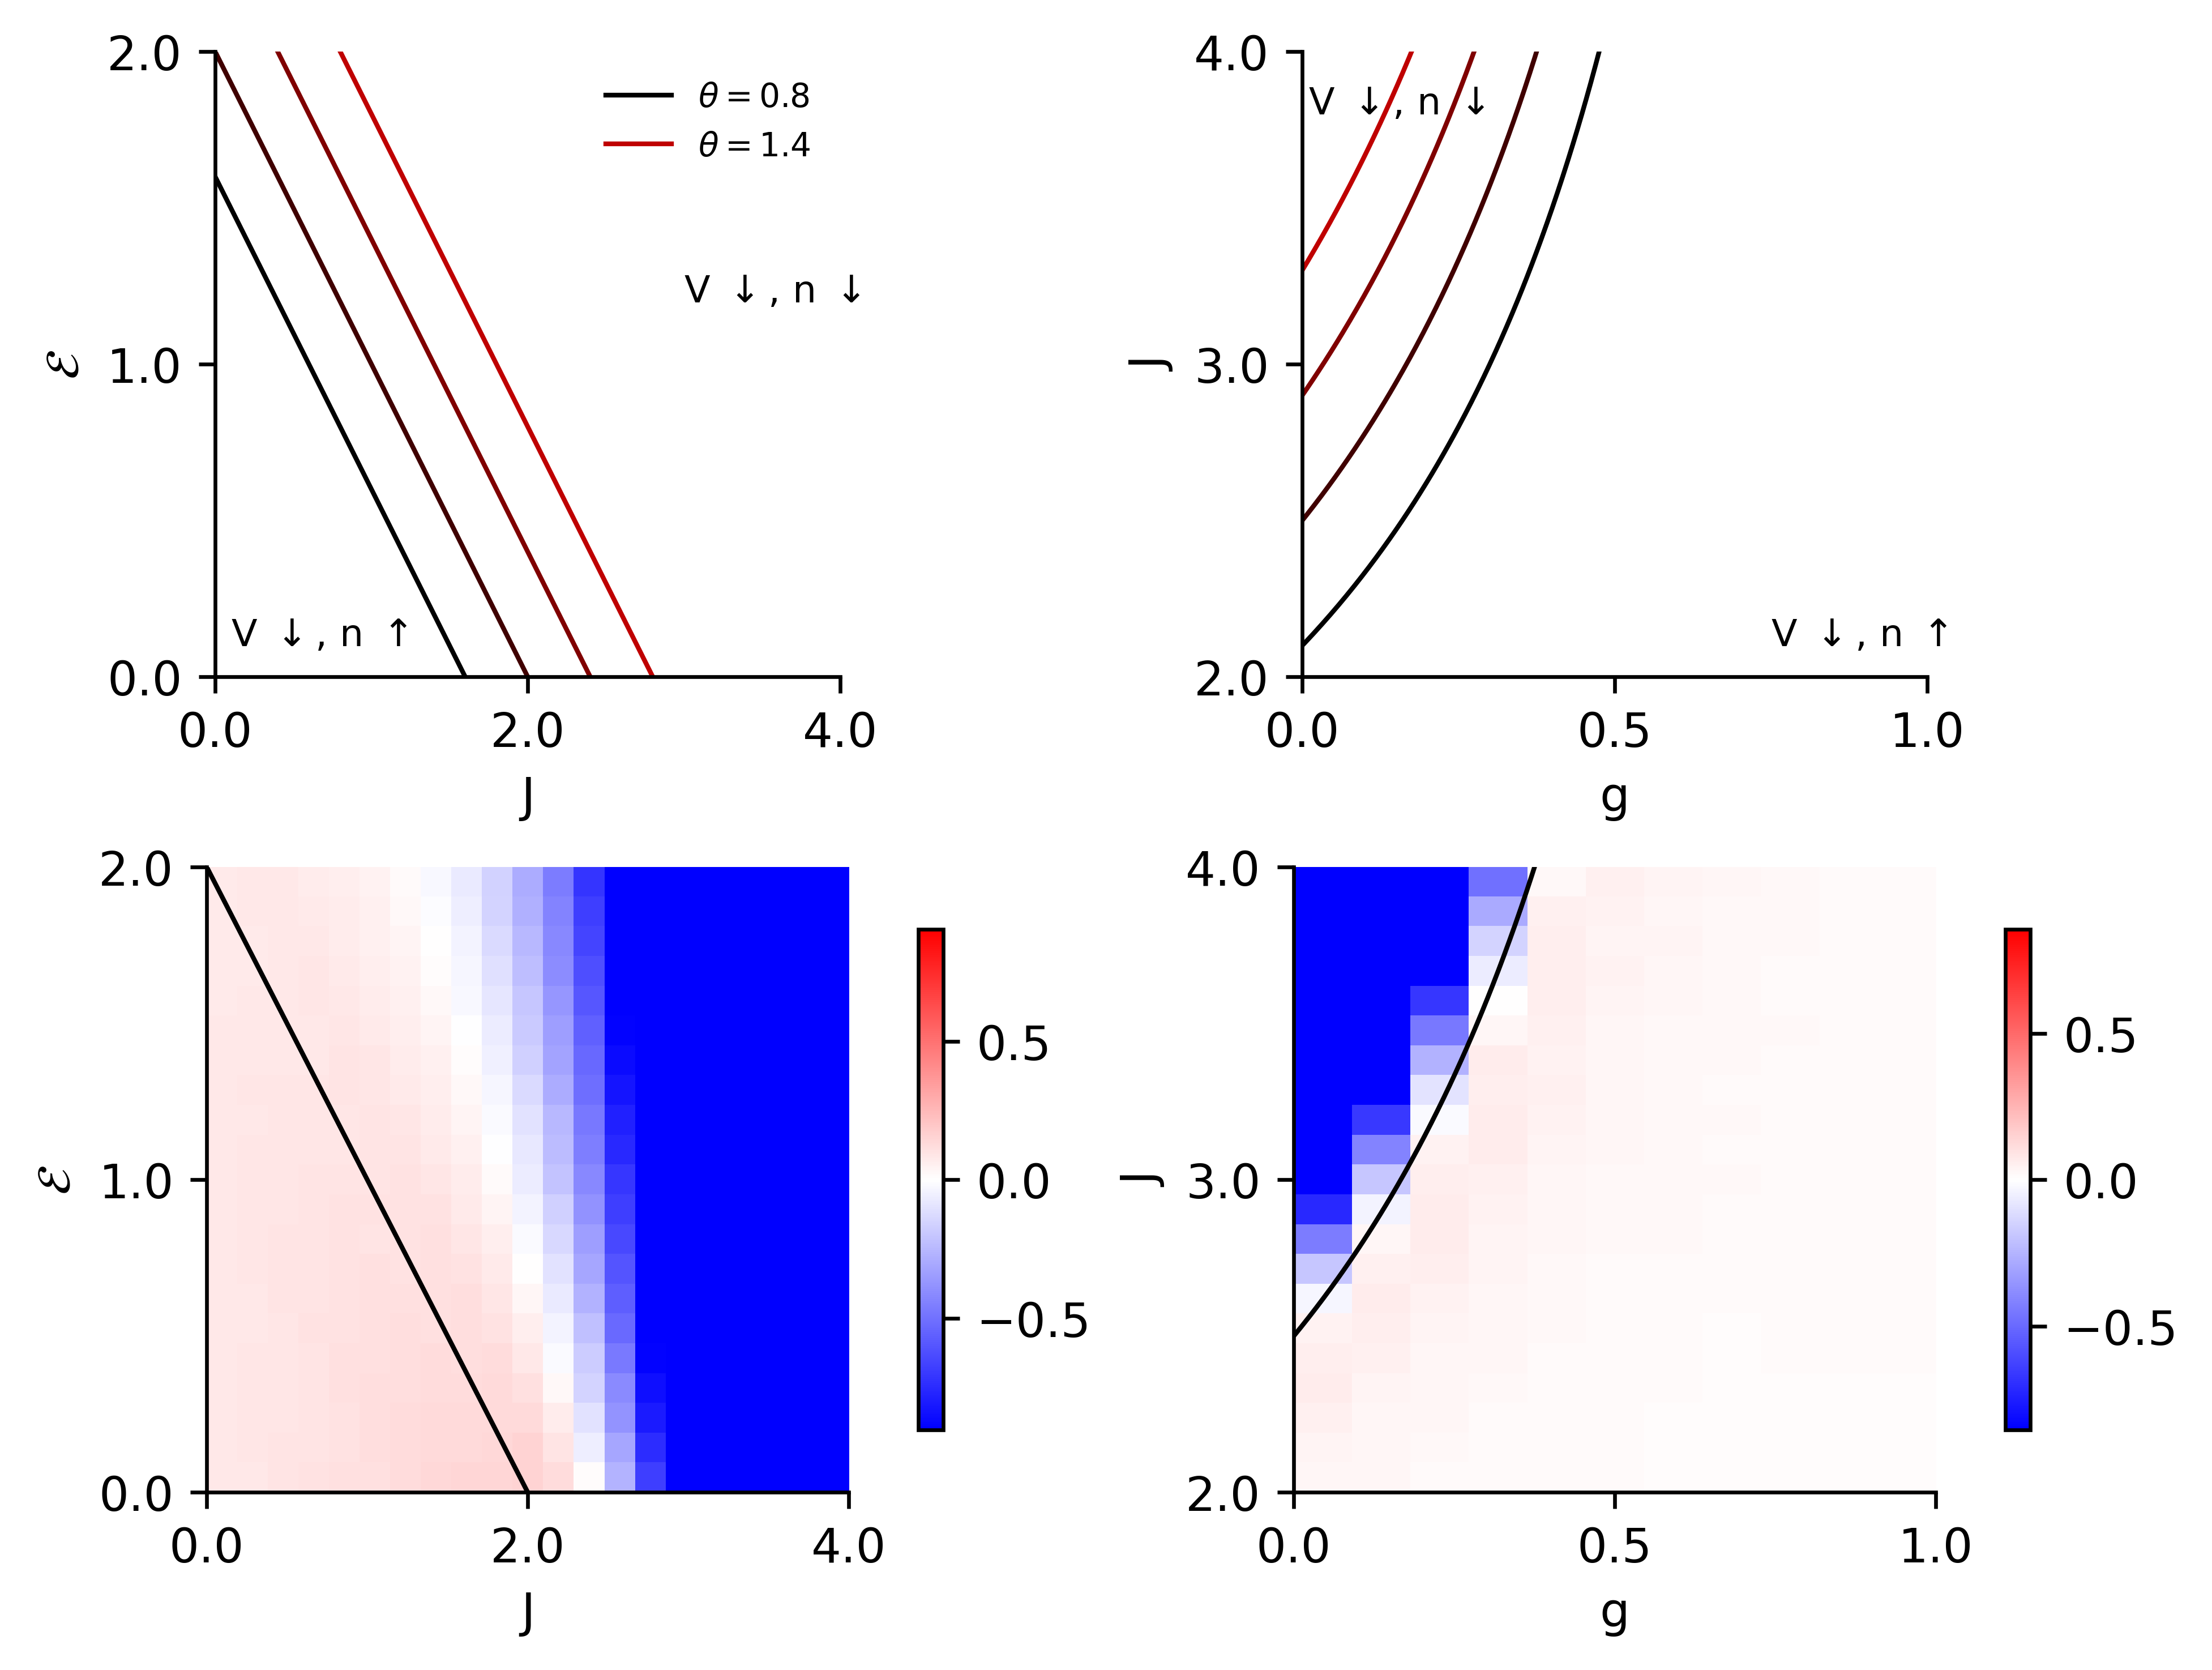

In [8]:
COLOR = (0., 0., 0.)

def color_conv(color_range):
    return (COLOR[0] + color_range, COLOR[1], COLOR[2]) 
    
fontsize=10
J_limL = -2.0
J_limH = 8.0
E_limL = 0.5
E_limH = 1.5

f, ax = plt.subplots(2,2,dpi=600,layout='constrained')

tt = 1 / len(theta)
for i in range(len(theta)):
    if i == 0 or i == len(theta)-1:
        ax[0, 0].plot(J, E_plot_theta[i,:], color=color_conv(i*tt), linewidth=1, label='$\\theta=$'+str(theta[i]))
    else:
        ax[0, 0].plot(J, E_plot_theta[i,:], color=color_conv(i*tt), linewidth=1)

ax[0, 0].set_xlabel('J')
ax[0, 0].set_ylabel('$\\mathcal{E}$')
ax[0, 0].text(0.1, 0.1, 'V $\\downarrow$, n $\\uparrow$', fontsize=8)
ax[0, 0].text(3.0, 1.2, 'V $\\downarrow$, n $\\downarrow$', fontsize=8)
xticks = [0.0, 2.0, 4.0]
yticks = [0.0, 1.0, 2.0]
ax[0, 0].set_xticks(xticks, xticks, fontsize=fontsize)
ax[0, 0].set_yticks(yticks, yticks, fontsize=fontsize)
ax[0, 0].set_xlim(xticks[0], xticks[-1])
ax[0, 0].set_ylim(yticks[0], yticks[-1])
ax[0, 0].legend(frameon=False, loc='upper right',fontsize=7)
ax[0, 0].set_aspect(1./ax[0,0].get_data_ratio())


tt = 1 / len(theta)
for i in range(len(theta)):
    ax[0, 1].plot(g_plot_theta[i,:], J, color=color_conv(i*tt), linewidth=1)

ax[0, 1].set_xlabel('g', fontsize=fontsize)
ax[0, 1].set_ylabel('J', fontsize=fontsize)
ax[0, 1].text(0.75, 2.1, 'V $\\downarrow$, n $\\uparrow$', fontsize=8)
ax[0, 1].text(0.01, 3.8, 'V $\\downarrow$, n $\\downarrow$', fontsize=8)
xticks = [0.0, 0.5, 1.0]
yticks = [2.0, 3.0, 4.0]
ax[0, 1].set_xlim(xticks[0], xticks[-1])
ax[0, 1].set_ylim(yticks[0], yticks[-1])
ax[0, 1].set_xticks(xticks, xticks, fontsize=fontsize)
ax[0, 1].set_yticks(yticks, yticks, fontsize=fontsize)
ax[0, 1].set_aspect(1./ax[0,1].get_data_ratio())


cmax = np.amax(np.abs(fr_Sim_H_EJ - fr_MF_H_EJ)) / 10
dE = E_plot[1] - E_plot[0]
dJ = J_plot[1] - J_plot[0]
Emin = E_plot[0]
Emax = E_plot[-1]
Jmin = J_plot[0]
Jmax = J_plot[-1]
im1 = ax[1, 0].imshow(fr_Sim_H_EJ - fr_MF_H_EJ, origin='lower', extent=(Jmin, Jmax, Emin, Emax), clim=(-cmax, cmax), cmap='bwr', aspect='auto')
f.colorbar(im1, ax=ax[1,0], shrink=0.8)
ax[1, 0].plot(J, E_plot_theta[1,:], 'k', linewidth=1)
ax[1, 0].set_xlabel('J', fontsize=fontsize)
ax[1, 0].set_ylabel('$\\mathcal{E}$', fontsize=fontsize)
# ax[1, 1].set_aspect(1./ax[1,1].get_data_ratio())
xticks = [0.0, 2.0, 4.0]
yticks = [0.0, 1.0, 2.0]
ax[1, 0].set_xticks(xticks, xticks, fontsize=fontsize)
ax[1, 0].set_yticks(yticks, yticks, fontsize=fontsize)
ax[1, 0].set_xlim(Jmin, Jmax)
ax[1, 0].set_ylim(Emin, Emax)

E_fixed = -0.5
g_plot_theta_temp = 1 - ((2 * 1.0 - E_fixed) / J) 
cmax = np.amax(np.abs(fr_Sim_L_Jg.T - fr_MF_L_Jg.T)) / 10
dg = g_plot[1] - g_plot[0]
dJ = J_plot[1] - J_plot[0]
gmin = g_plot[0]
gmax = g_plot[-1]
Jmin = J_plot_Jg[0]
Jmax = J_plot_Jg[-1]
im1 = ax[1, 1].imshow(fr_Sim_H_Jg.T - fr_MF_H_Jg.T, origin='lower', extent=(gmin, gmax, Jmin, Jmax), clim=(-cmax, cmax), cmap='bwr', aspect='auto')
f.colorbar(im1, ax=ax[1,1], shrink=0.8)
ax[1, 1].plot(g_plot_theta[1,:], J, color='k', linewidth=1)
ax[1, 1].set_xlabel('g', fontsize=fontsize)
ax[1, 1].set_ylabel('J', fontsize=fontsize)
# ax[1, 2].set_aspect(1./ax[1,2].get_data_ratio())
xticks = [0.0, 0.5, 1.0]
yticks = [2.0, 3.0, 4.0]
ax[1, 1].set_xticks(xticks, xticks, fontsize=fontsize)
ax[1, 1].set_yticks(yticks, yticks, fontsize=fontsize)
ax[1, 1].set_xlim(gmin, gmax)
ax[1, 1].set_ylim(Jmin, Jmax)

sns.despine(ax=ax[0, 0])
sns.despine(ax=ax[0, 1])
sns.despine(ax=ax[1, 0])
sns.despine(ax=ax[1, 1])

f.savefig('./Figures/Figure7.pdf', format='pdf')
plt.show()
